In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
from math import sin, cos, sqrt, atan2, radians
from ease_grid import EASE2_grid
grid_size = 36000
egrid = EASE2_grid(grid_size)
assert egrid.shape == (406, 964)

In [2]:
# Set the size bins
max_diameter=330
diam_bins = [5, 10, 50, 100]
diam_labs = ['005', '005-009', '010-050', '050-100', '100+']
diam_range = {'005':[1,5],'005-009':[5,9],'010-050':[10,50],'050-100':[50,100],'100+':[100,max_diameter]}
lambda_start = {'005':1,'005-009':1.1,'010-050':1.2,'050-100':1.4,'100+':1.8}
lambda_end = {'005':2,'005-009':4,'010-050':8,'050-100':16,'100+':32}

In [3]:
# Make dictionary with size bins and frequency
with open('sfd.csv', 'r') as f:
    freqs = pd.read_csv(f).groupby('D').sum()
los_dict = {i:0 for i in diam_labs}
his_dict = {i:0 for i in diam_labs}
for i in freqs.index.values:
    for j in range(len(diam_bins)):
        if i < diam_bins[j]:
            los_dict[diam_labs[j]] += freqs.loc[i,'low']
            his_dict[diam_labs[j]] += freqs.loc[i,'high']
            break
        elif i >= diam_bins[-1]:
            los_dict[diam_labs[-1]] += freqs.loc[i,'low']
            his_dict[diam_labs[-1]] += freqs.loc[i,'high']
            break
df_freq = pd.DataFrame.from_dict({'high':his_dict, 'low':los_dict, 
                                  'lambda_start':lambda_start, 'lambda_end':lambda_end})
df_freq['frequency_factor'] = [0.1,0.2,0.3,0.6,0.8]
df_freq

,high,low,lambda_start,lambda_end,frequency_factor
005,16950000,1695000,1.0,2,0.1
005-009,855000,85500,1.1,4,0.2
010-050,146100,14610,1.2,8,0.3
050-100,8700,870,1.4,16,0.6
100+,3050,305,1.8,32,0.8


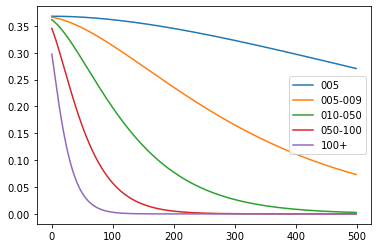

total impacts 15978615.0
impacts by diameter {'005': 15822340.0, '005-009': 91199.0, '010-050': 62193.0, '050-100': 1199.0, '100+': 1684.0}
fraction of total {'005': 0.99, '005-009': 0.01, '010-050': 0.0, '050-100': 0.0, '100+': 0.0}


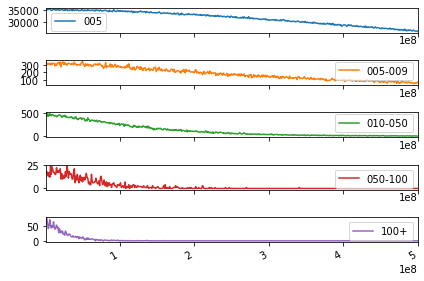

,high,low,lambda_start,lambda_end,frequency_factor,total
005,16950000,1695000,1.0,2,0.000010,15822340.0
005-009,855000,85500,1.1,4,0.001148,91199.0
010-050,146100,14610,1.2,8,0.000780,62193.0
050-100,8700,870,1.4,16,0.016811,1199.0
100+,3050,305,1.8,32,0.004390,1684.0


In [4]:
t_total=500

fivehundredmillion = 500000000
freq_factor = fivehundredmillion/t_total

not_converged=True
while not_converged:

    pp = {x:np.zeros(t_total) for x in diam_labs}
    l = {x:np.linspace(y,z,t_total) for x,y,z in zip(diam_labs,df_freq['lambda_start'],df_freq['lambda_end'])}

    for D in diam_labs:
        pp[D] = l[D]*np.exp(-l[D])

    df = pd.DataFrame(data=pp)
    hits = {d:np.zeros(t_total) for d in diam_labs}

    # Main loop through time. Calculate the total number of impacts of each diameter at each time step
    for t in range(0,t_total):
        for D in diam_labs:
            hits[D][t] = np.floor(np.random.poisson(pp[D][t] / df_freq.loc[D, 'frequency_factor']))


    total_sum = np.sum([hits[d] for d in diam_labs])
    sums = {d:np.sum(hits[d]) for d in diam_labs}
    frac = {d:np.round(np.sum(hits[d])/total_sum,2) for d in diam_labs}
    
    for d in diam_labs:
        df_freq.loc[d,'total']=sums[d]
    
    good_numbers = 0
    for d in diam_labs:
        if df_freq.loc[d,'total'] < df_freq.loc[d,'low']:
            df_freq.loc[d,'frequency_factor'] = df_freq.loc[d,'frequency_factor']*random.random()
        elif df_freq.loc[d,'total'] > df_freq.loc[d,'high']:
            df_freq.loc[d,'frequency_factor'] = df_freq.loc[d,'frequency_factor']*(1+random.random())
        else:
            good_numbers+=1
    if good_numbers == df_freq.shape[0]:
        not_converged = False
    
    
    
plt.plot(df)
plt.legend(df.columns.values)
plt.show()
print('total impacts', total_sum)
print('impacts by diameter', sums)
print('fraction of total', frac)
plot_time = np.linspace(0,fivehundredmillion,t_total+1)[1:]
df = pd.DataFrame(data=hits, index=plot_time)
df.plot(subplots=True)
plt.tight_layout()
plt.show()
df_freq

In [5]:
# approximate radius of earth in km
def distance(lat1,lat2,lon1,lon2):
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return(distance) #km

In [6]:
class IMPAaCS:
    
    count_test_hits = 0
    impact_test_id = str(round(-87.5726,4))+' '+str(round(33.2921,4))
    grid_cell_state = {}
    impacted_grid_cells = []
    impactors_at_test_cell = [0]
    test_time = [0]
    
    def __init__(self, egrid, 
                 max_depth_of_impact_melt=330,
                 primitive_initial_state=45,
                 fraction_upper_layer = 2/3,
                 target_SiO2 = 62.58,     # From sudbury
                 upper_SiO2 = 68.71,      # From sudbury
                 n_layers_impact_melt = 2,
                 z_discretized_km = int(2),
                 proportion_melt_from_impact = 1/3,
                 sim_time=0):
        self.egrid = egrid
        self.primitive_initial_state = primitive_initial_state
        self.max_depth_of_impact_melt = max_depth_of_impact_melt
        self.fraction_upper_layer = fraction_upper_layer        # d_upper / Mi (from Sudbury)
        self.fraction_lower_layer = 1-self.fraction_upper_layer # d_lower / Mi (from Sudbury)
        self.n_layers_impact_melt = n_layers_impact_melt
        self.target_SiO2 = target_SiO2 # From sudbury
        self.upper_SiO2 = upper_SiO2  # From sudbury
        self.z_discretized_km = z_discretized_km
        self.proportion_melt_from_impact = proportion_melt_from_impact
        self.average_target = self.primitive_initial_state
        self.average_target_list = [self.primitive_initial_state]
        self.top_layer_at_test_cell = [self.primitive_initial_state]
        self.average_test_target_list = [self.primitive_initial_state]
        self.state_prep()

    #--------------------------------------------------------------------------------------------------
    def update(self, impact_loc, impactor_diameter, sim_time=0):
        self.sim_time = sim_time
        self.impact_dimensions(impactor_diameter)
        self.find_the_grid(impact_loc)
        self.get_average_target(impactor_diameter)
        self.loop_impact_grid(impactor_diameter)
        
    #--------------------------------------------------------------------------------------------------
    #---- THIS IS THE MAIN CODE -------------------- THIS IS THE MAIN CODE ----------------------------
    #--------------------------------------------------------------------------------------------------
    def state_dynamics(self, impactor_diameter, grid_cell_id):
        """
        This is the critical component of this model
        This function will change the chemical makeup of each grid cell
            according to the chemical theory put forward by Faltys-Wielicki [2021]
        """
        
        #####      DYNAMIC FACTORS       ############################
        depth_of_impact_melt = impactor_diameter * self.proportion_melt_from_impact # D/3

        #Vertical discretization.
        melt_layers = int(depth_of_impact_melt / self.z_discretized_km)

        lower_layer  = range(int(round(self.fraction_upper_layer * melt_layers,2)), melt_layers)
        upper_layer  = range(0, int(round(self.fraction_upper_layer * melt_layers,2)))

        fracionated_melt = depth_of_impact_melt * self.fraction_upper_layer #Units: km

        fractionation_factor = 1 - (self.target_SiO2 / self.upper_SiO2)

        #####      DO THE DYANMICS       #############################
        # Set lower layer to primitive initial state.  
        for i in lower_layer:
            self.grid_cell_state[grid_cell_id][i] = self.primitive_initial_state

        # Impact melt portion  (Upper)
        for i in upper_layer:
            self.grid_cell_state[grid_cell_id][i] = self.average_target / (1 - fractionation_factor)

        # Weighted average of upper    
        wt_sio2_upper = self.grid_cell_state[grid_cell_id][0]

        # Lower of impact melt portion
        for i in lower_layer:
            numerator = self.average_target-(self.fraction_upper_layer * wt_sio2_upper)
            self.grid_cell_state[grid_cell_id][i] = numerator / self.fraction_lower_layer

        for i in range(melt_layers):
            self.grid_cell_state[grid_cell_id][i] = np.round(self.grid_cell_state[grid_cell_id][i],1)
    
    #--------------------------------------------------------------------------------------------------    
    def state_prep(self):
        total_layers = int(self.max_depth_of_impact_melt / self.z_discretized_km)
        for ilon in self.egrid.londim:
            for ilat in self.egrid.latdim:
                grid_cell_id = str(round(ilon,4))+' '+str(round(ilat,4))
                self.grid_cell_state[grid_cell_id] = np.ones(total_layers) * self.primitive_initial_state
    
    #--------------------------------------------------------------------------------------------------    
    def get_average_target(self, impactor_diameter):
        average_target = 0
        for grid_cell in self.impacted_grid_cells:
            grid_cell_id = str(round(grid_cell[0],4))+' '+str(round(grid_cell[1],4))
            ### If the grid cell has not been hit yet, it is the initial primitive value
            if grid_cell_id in self.grid_cell_state.keys():
                average_target += np.sum(self.grid_cell_state[grid_cell_id][:self.z_layers])
            else:
                average_target += self.primitive_initial_state * self.z_layers
        self.average_target = average_target/(len(self.impacted_grid_cells) * self.z_layers)
        
    #--------------------------------------------------------------------------------------------------    
    def find_the_grid(self, impact_loc):
        self.impacted_grid_cells = [] # first reset the impacted grid cells, then fill them up
        for ilon in self.egrid.londim:
            for ilat in self.egrid.latdim:
                D = distance(impact_loc[0],ilat,impact_loc[1],ilon)
                if D < self.crator_radius:
                    self.impacted_grid_cells.append([ilon, ilat])
        if len(self.impacted_grid_cells) < 1:
            print("Warning. There are no grids impacted!")
            print(impact_loc)

    #--------------------------------------------------------------------------------------------------    
    def loop_impact_grid(self, impactor_diameter):
        for grid_cell in self.impacted_grid_cells:
            grid_cell_id = str(round(grid_cell[0],4))+' '+str(round(grid_cell[1],4))

            ################      DO THE DYANMICS       #############################
            self.state_dynamics(impactor_diameter, grid_cell_id)

            self.test_one_grid_cell(grid_cell_id, impactor_diameter)
    #--------------------------------------------------------------------------------------------------    
    def impact_dimensions(self, impactor_diameter):
            # The impact crator is 10*Diameter, so the radius is half that
            self.crator_diameter = 10*impactor_diameter
            self.crator_radius = self.crator_diameter/2
            self.z_layers = int(np.ceil(impactor_diameter / self.z_discretized_km))

    #--------------------------------------------------------------------------------------------------    
    def test_one_grid_cell(self, grid_cell_id, impactor_diameter):
        ##### Testing one cell:
        if grid_cell_id == self.impact_test_id:
            self.count_test_hits+=1
            self.test_time.append(self.sim_time)
            self.impactors_at_test_cell.append(impactor_diameter)
            self.average_test_target_list.append(self.average_target)
            self.top_layer_at_test_cell.append(self.grid_cell_state[self.impact_test_id][0])

In [7]:
Impc = IMPAaCS(egrid, max_depth_of_impact_melt=330)
# Loop through impacts, the df has them stored by time and diameter bn
for it, t in enumerate(df.index.values):
    print('time', it)
    for d in diam_labs[3:]:
        for i in range(int(df.loc[t,d])):

            # locate the the impacts on earth
            impact_lat = random.randrange(-90,90)
            impact_lon = random.randrange(-180,180)
            if np.abs(impact_lat) > 79:
                continue
            impact_loc = [impact_lat, impact_lon]
            impactor_diameter = random.randrange(diam_range[d][0],diam_range[d][1])
                
            #####      DO THE DYANMICS       #############################
            Impc.update(impact_loc, impactor_diameter, t)
    

time 0
time 1
time 2
time 3
time 4
time 5
time 6
time 7
time 8
time 9
time 10
time 11
time 12
time 13
time 14
time 15
time 16
time 17
time 18
time 19
time 20
time 21
time 22
time 23
time 24
time 25
time 26
time 27
time 28
time 29
time 30
time 31
time 32
time 33
time 34
time 35
time 36
time 37
time 38
time 39
time 40
time 41
time 42
time 43
time 44
time 45
time 46
time 47
time 48
time 49
time 50
time 51
time 52
time 53
time 54
time 55
time 56
time 57
time 58
time 59
time 60
time 61
time 62
time 63
time 64
time 65
time 66
time 67
time 68
time 69
time 70
time 71
time 72
time 73
time 74
time 75
time 76
time 77
time 78
time 79
time 80
time 81
time 82
time 83
time 84
time 85
time 86
time 87
time 88
time 89
time 90
time 91
time 92
time 93
time 94
time 95
time 96
time 97
time 98
time 99
time 100
time 101
time 102
time 103
time 104
time 105
time 106
time 107
time 108
time 109
time 110
time 111
time 112
time 113
time 114
time 115
time 116
time 117
time 118
time 119
time 120
time 121
time 122
tim

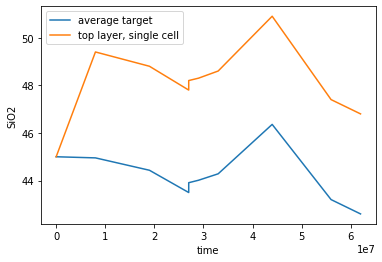

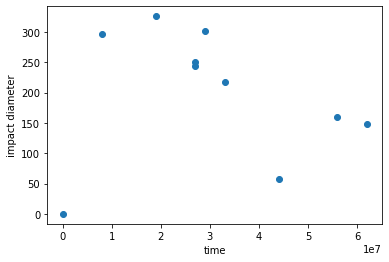

In [9]:
plt.plot(Impc.test_time, Impc.average_test_target_list)
plt.plot(Impc.test_time, Impc.top_layer_at_test_cell)
plt.legend(["average target", "top layer, single cell"])
plt.xlabel("time")
plt.ylabel("SiO2")
plt.show()
plt.close()
plt.scatter(Impc.test_time, Impc.impactors_at_test_cell)
plt.ylabel("impact diameter")
plt.xlabel("time")
plt.show()
plt.close()

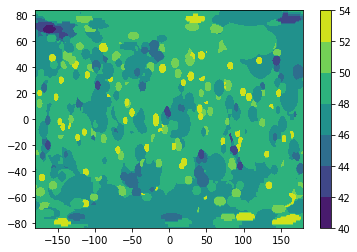

In [99]:
n_x = egrid.londim.shape[0]
n_y = egrid.latdim.shape[0]

z = np.zeros([n_x, n_y])
#i=0
for i, ilon in enumerate(egrid.londim):
    for j, ilat in enumerate(egrid.latdim):
        grid_cell = str(round(ilon,4))+' '+str(round(ilat,4))
        z[i, j] = np.mean(Impc.grid_cell_state[grid_cell][0:2])
#        i+=1

X, Y = np.meshgrid(egrid.londim, egrid.latdim)
#Z = np_plot[:,2].reshape(n_y, n_x)

plt.contourf(X, Y, np.transpose(z))
plt.colorbar()

In [ ]:
### This is only a test. I am forcing impacts at one location to test the dynamics
### This is only a test. I am forcing impacts at one location to test the dynamics
### This is only a test. I am forcing impacts at one location to test the dynamics
print("This is only a test. I am forcing impacts at one location to test the dynamics")
print("This is only a test. I am forcing impacts at one location to test the dynamics")
I = IMPAaCS(egrid)
impact_test_diameters = [330, 73, 16, 10, 5, 2, 330, 73, 16, 10, 5, 2]
# Loop through impacts, the df has them stored by time and diameter bn
for it, t in enumerate(df.index.values):
    print('time', it)
    for d in diam_labs[3:]:
        for i in range(int(df.loc[t,d])):

            # locate the the impacts on earth
            impact_lat = random.randrange(-90,90)
            impact_lon = random.randrange(-180,180)
            impact_loc = [impact_lat, impact_lon]

            # Specify the diameter within the bin
            if it < len(impact_test_diameters):                  # Test scenario
                impactor_diameter = impact_test_diameters[it]    # Test scenario
                impact_lat = 33.2921                             # Test scenario
                impact_lon = -87.5726                            # Test scenario
                impact_loc = [impact_lat, impact_lon]            # Test scenario
            else:                                                # Test scenario
                impactor_diameter = random.randrange(diam_range[d][0],diam_range[d][1])
                
            #####      DO THE DYANMICS       #############################
            I.update(impact_loc, impactor_diameter)

            break  # Test scenario

        if it < len(impact_test_diameters):   # Test scenario
            print("This is only a test. I am forcing impacts at one location to test the dynamics")
            print('{} diameter IMPAaC at Test cell: {}'.format(impactor_diameter, 
                                                               I.impact_test_id))
            print('average_target: {}, across {} grid cells'.format(np.round(I.average_target,1), 
                                                            len(I.impacted_grid_cells)))
            print("SiO2 states:")
            print(list(I.grid_cell_state[I.impact_test_id])[0:75])
            print(" ")
        break  # Test scenario

    if it > len(impact_test_diameters):  # Test scenario
        break  # Test scenario

In [ ]:
plt.plot(I.test_time, I.average_test_target_list)
plt.plot(I.test_time, I.top_layer_at_test_cell)
plt.legend(["average target", "top layer, single cell"])
plt.xlabel("time")
plt.ylabel("SiO2")
plt.show()
plt.close()
plt.scatter(I.test_time, I.impactors_at_test_cell)
plt.ylabel("impact diameter")
plt.xlabel("time")
plt.show()
plt.close()